This workbook is for extracting WK255 data and recreating the plots.

File structure: 
```
(root)
├── src
│    └── Python Test.ipynb
└── wairakei_data
     └── Liquid wells (version 1).xlsx
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    xl
except:
    xl = pd.ExcelFile('../wairakei_data/Liquid wells (version 1).xlsx')
print(xl.sheet_names[:5], '...')

['WK26A', 'WK26A trend ', 'WK26A trend  (2)', 'WK26B', 'WK26B trend '] ...


In [4]:
# remove rows at end
df = xl.parse('wk256')
df = df.loc[:, ~df.columns.str.contains('^Unnamed|SUMMARY')]
df['mf'] = pd.to_numeric(df['mf'], errors='coerce')
df = df.dropna(subset=['date', 'whp', 'mf'])
df = df[pd.notnull(df['date'])]
print(df.head())

        date        whp          mf            h      mf eqn        h eqn  \
0 2009-01-14  11.570806  457.311678  1030.000000  457.311673  1030.000000   
1 2009-01-14  12.930702  273.233802  1030.000000  273.233793  1030.000000   
3 2009-04-23  11.875385  458.231164  1059.775236  460.994348  1053.278602   
4 2009-04-23  12.499091  388.499626  1035.445714  382.333043  1047.768032   
5 2009-04-23  13.179032  260.347620  1047.723712  264.560564  1041.760614   

        diff       whp^2           MF^2  slope  intercept  
0   0.000000  133.883541  209133.970458    NaN        NaN  
1   0.000000  167.203064   74656.710685    NaN        NaN  
3  -6.496634  141.024760  209975.799564    NaN        NaN  
4  12.322318  156.227274  150931.959775    NaN        NaN  
5  -5.963098  173.686891   67780.883394    NaN        NaN  


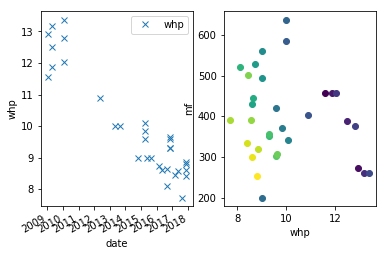

In [5]:
# create exploratory plots

cmap = plt.get_cmap('viridis')
indices = np.linspace(0, cmap.N, len(df))
my_colors = [cmap(int(i)) for i in indices]

fig, (ax1, ax2) = plt.subplots(1,2)

df.plot('date', 'whp', style='x', ax=ax1)
ax1.set_xlabel('date')
ax1.set_ylabel('whp')

for i, idx in enumerate(df.index):
    ax2.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])
# df.plot('whp', 'mf', ax=ax2, style='o')
ax2.set_xlabel('whp')
ax2.set_ylabel('mf')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                     mf   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     9.331
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           0.000744
Time:                        11:25:59   Log-Likelihood:                -186.06
No. Observations:                  32   AIC:                             378.1
Df Residuals:                      29   BIC:                             382.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1874.1872    343.103      5.462   

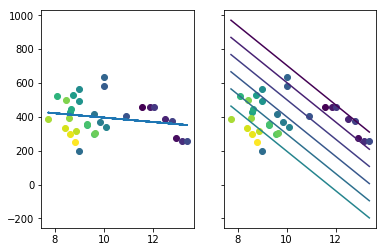

In [16]:
# fit regression model

from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

# convert date to a numeric value (days since first)
df['date_numeric'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')

# generate prediction data for plotting
date_pred = np.linspace(np.min(df['date_numeric']), np.max(df['date_numeric']), 6)
# date_pred = pd.to_datetime(date_pred)
whp_pred = whp_pred.flatten()
pred = pd.DataFrame(list(product(date_pred, whp_pred)), columns=['date_numeric', 'whp'])

# method 1
model = ols("mf ~ whp", data=df)
results = model.fit()

pred['mf'] = results.predict(pred)

# plot
indices = np.linspace(0, cmap.N, len(df))
my_colors = [cmap(int(i)) for i in indices]
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
for i, idx in enumerate(df.index):
    ax1.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])
    ax2.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])

ax1.plot(pred['whp'], pred['mf'])

# method 2
# model = ols("mf ~ whp + C(date)", data=df)
model = ols("mf ~ whp + date_numeric", data=df)
results = model.fit()
print(results.summary())

pred['mf'] = results.predict(pred)
print(pred)

# plot
indices = np.linspace(0, cmap.N, len(pred))
my_colors = [cmap(int(i)) for i in indices]
for i, date in enumerate(date_pred):
    ax2.plot(pred['whp'][pred['date_numeric']==date], pred['mf'][pred['date_numeric']==date], color=my_colors[i])


plt.show()